In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Function definition

In [6]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])

# Scaling and rotating
def scale(X, sx, sy):
    # Center the data to the origin
    mean = np.mean(X, 0)
    X = X - mean
    
    # Scaling matrix
    Scale = np.array([[sx, 0], [0, sy]])

    # Apply transformation matrix to X
    Y = X.dot(Scale)
    return Y + mean

def rotate(X, theta):
    # Rotation matrix
    theta = theta * np.pi/180
    c, s = np.cos(theta), np.sin(theta)
    Rot = np.array([[c, -s], [s, c]])

    # Apply transformation matrix to X
    Y = X.dot(Rot)
    return Y

## Creating 2 variables gaussian distribution

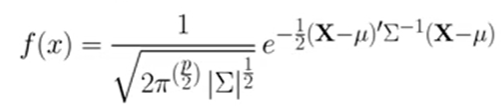

correlation : 
 [[ 1.         -0.11609129]
 [-0.11609129  1.        ]]
covariance : 
 [[ 8.55120654 -0.99685778]
 [-0.99685778  8.62262987]]


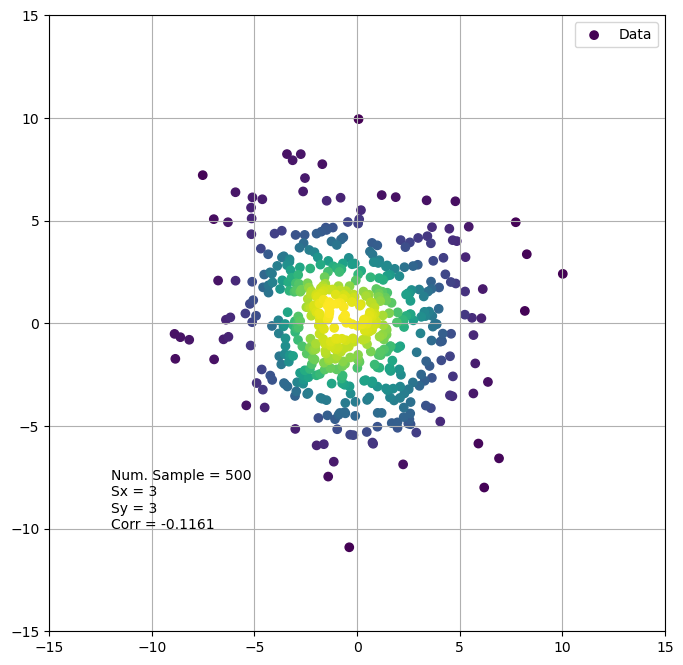

In [8]:
# Normal distributed x and y vector with mean 0 and standard deviation 1
num_samples = 500
corr = -0.2 # expected correlation of x to y
mx, my = 0, 0
sx, sy = 3, 3
cov_matrix = [[sx**2      ,   sx * sy * corr],
       [sx * sy * corr,         sy**2]]

Y = np.random.multivariate_normal([mx,my], cov_matrix, num_samples)

x_cut = np.linspace(-10,10,num_samples)
y_cut = -1.5 * x_cut
y_cut2 = -0.6 * x_cut - 1
y_cut3 = -1.1 * x_cut + 1

Y_cut = Y.copy()

for i in range(len(x_cut)):
    if (Y_cut[:, 1][i] < Y_cut[:, 0][i]*-1.1 + 1) and (Y_cut[:, 1][i] > Y_cut[:, 0][i]*-0.6-1):
        Y_cut[:, 1][i] = Y[:, 1][i]
    else:
        Y_cut[:, 1][i] = -99
        
Y_cut = Y_cut[Y_cut[:, 1] != -99]
# Y = rotate(Y, 30)

# Y = Y_cut.copy()

from scipy.stats import gaussian_kde
z = gaussian_kde(Y.T)(Y.T)
idx = z.argsort()
Y[:, 0], Y[:, 1], z = Y[:, 0][idx], Y[:, 1][idx], z[idx]

# Calculate covariance matrix
C = cov_mat(Y.T)
correlation = np.corrcoef(Y[:,0], Y[:,1])
print('correlation : \n',correlation)
print('covariance : \n',C)

plt.rcParams['figure.figsize'] = (12, 8)
plt.scatter(Y[:, 0], Y[:, 1], label='Data',c=z)
# plt.title('Transformed Data')
# plt.scatter(Y_cut[:,0], Y_cut[:,1], label='Data_Cut')
# plt.plot(x_cut, y_cut3, color='red',label='Cutting line')
# plt.plot(x_cut, y_cut2, color='red')
plt.legend()
plt.text(-12,-10,f'Num. Sample = {num_samples}\nSx = {sx}\nSy = {sy}\nCorr = {np.round(correlation[0][1],4)}')
plt.grid()
plt.gca().set_aspect('equal')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()



## Folded Polar Coordinate Fitting

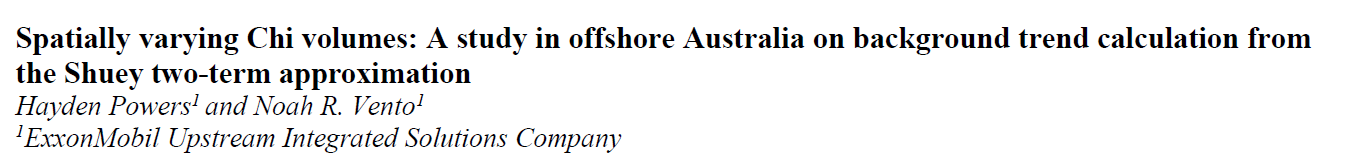

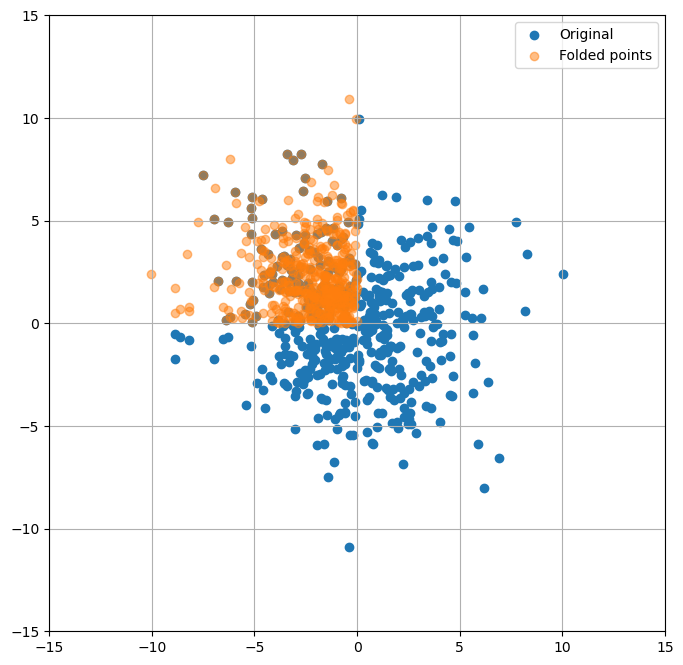

-44.84737233297395


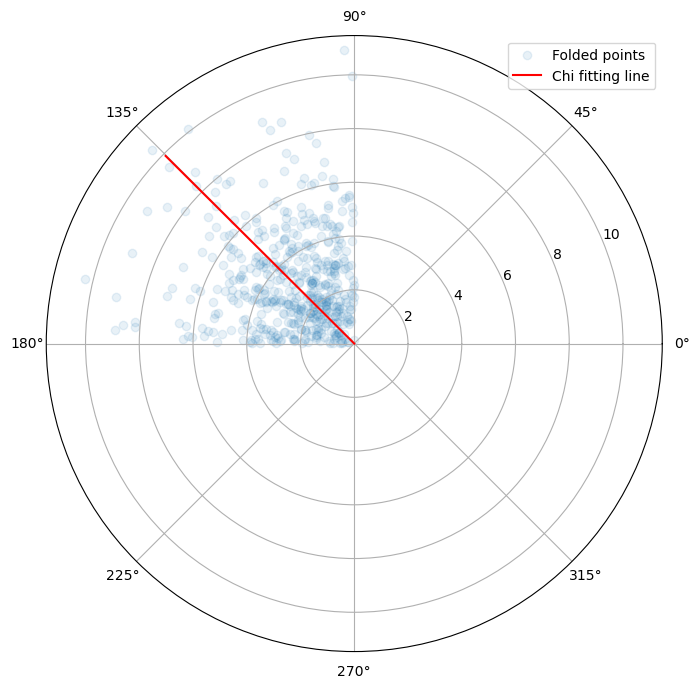

In [9]:
def cartesian2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan(y/x)
    return theta, r

# Fold 
x_fold = Y[:, 0].copy()
y_fold = Y[:, 1].copy()

for i in range(len(x_fold)):
    if x_fold[i] > 0:
        x_fold[i] = -x_fold[i]
    if y_fold[i] < 0:
        y_fold[i] = -y_fold[i]
plt.figure()        
plt.scatter(Y[:, 0], Y[:, 1], label='Original')
plt.scatter(x_fold,y_fold, label='Folded points', alpha=0.5)
plt.grid()
plt.gca().set_aspect('equal')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.legend()
plt.show()

for i in range(len(x_fold)):
    if x_fold[i] > 0:
        x_fold[i] = -x_fold[i]
    if y_fold[i] < 0:
        y_fold[i] = -y_fold[i]

n , d = 0, 0
theta, r = [], []
for i in range(len(x_fold)):
    theta_i, r_i = cartesian2polar(x_fold[i],y_fold[i])
    theta.append(theta_i+np.pi)
    r.append(r_i)
    a = 2
    n = n + np.sin(theta_i) * r_i**a
    d = d + np.cos(theta_i) * r_i**a
    
chi = np.arctan(n/d) * 180/np.pi 
print(chi)

r_plot = np.arange(0, 10, 0.1)
theta_plot = np.ones(len(r_plot)) * chi * np.pi /180

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(theta, r, alpha=0.1, label='Folded points')
ax.plot(theta_plot+np.pi, r_plot,color='red', label='Chi fitting line')
# ax.set_thetamin(0)
# ax.set_thetamax(180)
plt.legend()
plt.show()

## PCA and Regression

In [10]:
# PCA
def pca(C):
    eigenvalues, eigenvectors = np.linalg.eig(C)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    principal_axis_vector = sorted_eigenvectors[:, 0]
    normalized_principal_axis_vector = principal_axis_vector / np.linalg.norm(principal_axis_vector)
    m_principal = normalized_principal_axis_vector[1] / normalized_principal_axis_vector[0]
    return m_principal

# Least Square Regression 
def regression(x, y):
    x_center = x - np.mean(x)
    y_center = y - np.mean(y)
    m = 1 / np.dot(x_center.T,x_center) * np.dot(x_center.T,y_center)
    c = (np.sum(y) - np.sum(x)*m) / len(y_center) # average of intercept
    return m, c

m_principal = pca(C)
print(m_principal)

m_regression, c = regression(Y[:, 0], Y[:, 1])
print(m_regression,c)

x = np.linspace(-7.5,7.5,100)
y_principal = [i * m_principal for i in x]
y_regression = [i * m_regression + c for i in x]

-1.0364657132133404
-0.11657510210248868 0.05120473179230133


## Plotting together

-0.9946864313709836


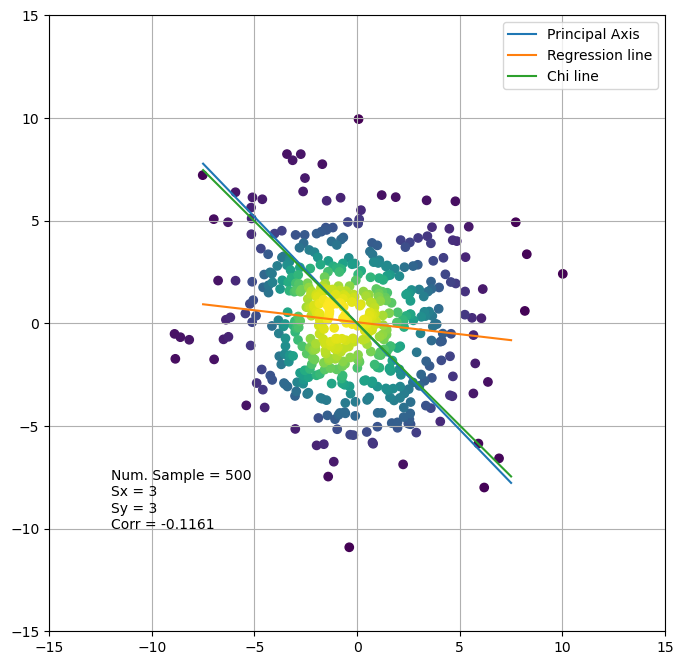

In [11]:
m_chi = np.tan(chi *np.pi/180)

print(m_chi)
x = np.linspace(-7.5,7.5,100)
y_chi = [i * m_chi for i in x]

from scipy.stats import gaussian_kde
z = gaussian_kde(Y.T)(Y.T)
idx = z.argsort()
Y[:, 0], Y[:, 1], z = Y[:, 0][idx], Y[:, 1][idx], z[idx]

plt.scatter(Y[:, 0], Y[:, 1], c=z)
plt.plot(x,y_principal, label='Principal Axis')
plt.plot(x,y_regression, label='Regression line')
plt.plot(x,y_chi, label='Chi line')
plt.grid()
plt.gca().set_aspect('equal')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.text(-12,-10,f'Num. Sample = {num_samples}\nSx = {sx}\nSy = {sy}\nCorr = {np.round(correlation[0][1],4)}')
plt.legend()
plt.show()

## Kernel density function (KDE)

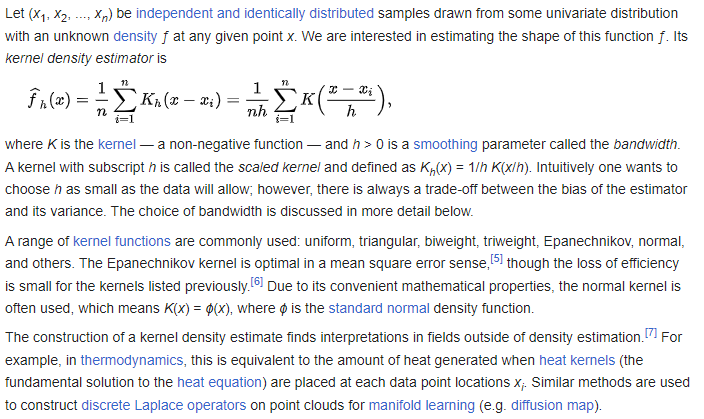